# Dense Sentiment Classifier

In this notebook, we build a dense neural net to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [1]:
import keras
# the dataset
from keras.datasets import imdb
# for sequence padding
from keras.preprocessing.sequence import pad_sequences
# model type: sequential
from keras.models import Sequential
# usual layers
from keras.layers import Dense, Flatten, Dropout
# for NLP, embedding layer
from keras.layers import Embedding # new!
# saving the results frm each epoch
from keras.callbacks import ModelCheckpoint # new! 
import os # new! 
# using the ROC_AUC as a metric 
from sklearn.metrics import roc_auc_score, roc_curve # new!
import pandas as pd
import matplotlib.pyplot as plt # new!
%matplotlib inline

Using TensorFlow backend.


#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/dense'

# training:
epochs = 4
batch_size = 128 #the mini batchsize for gradient descent

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 # as per Maas et al. (2011); may not be optimal
n_words_to_skip = 50 # ditto; the most commun words to skip
max_review_length = 100 # if the review has more it will be truncated
pad_type = trunc_type = 'pre' # if less than 100, the review should be padded, 'pre'= operating at the begining; either in truncating or padding

# neural network architecture: 1 dense layer, 64 neurons at the begining, droping out half
n_dense = 64
dropout = 0.5

#### Load data

For a given data set: 

* the Keras text utilities [here](https://keras.io/preprocessing/text/) quickly preprocess natural language and convert it into an index
* the `keras.preprocessing.text.Tokenizer` class may do everything you need in one line:
    * tokenize into words or characters
    * `num_words`: maximum unique tokens
    * filter out punctuation
    * lower case
    * convert words to an integer index

In [3]:
# valid==test, a good point made by the author about the ditinction between test and validation
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words, skip_top=n_words_to_skip) 

17465344/17464789 [==============================] - 18s    


In [4]:
x_train[0:2] 
#Reserved:  0 reserved for padding; 1 would be starting character; 2 is unknown; 3 is most common word, 4 second most commun, ..... etc.

array([ list([2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]),
       list([2, 194, 1153, 194, 2, 78, 228, 2, 2, 1463, 4369, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 2

In [5]:
#checking the lenth
for x in x_train[0:6]:
    print(len(x))

218
189
141
550
147
43


In [6]:
# the classification of the first 6 reviews
y_train[0:6]

array([1, 0, 0, 1, 0, 0])

In [6]:
# the sizes of training and validation sets
len(x_train), len(x_valid)

(25000, 25000)

#### Restoring words from index

In [7]:
word_index = keras.datasets.imdb.get_word_index()
# starting from 3; the rest were reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2

1589248/1641221 [============================>.] - ETA: 0s

In [8]:
word_index

{'suwa': 31248,
 "wrap'ed": 71215,
 'artisan': 29104,
 'starkest': 52800,
 "'homosexual": 54816,
 "manufacturer's": 53543,
 'authoring': 60149,
 'handpicked': 51371,
 'dodekakuple': 83968,
 'emission': 66133,
 'apprehensions': 69443,
 "ballad'": 88045,
 'spidey': 25022,
 "mortimer's": 37417,
 'strangelove': 11465,
 "cruel'": 77276,
 'unfaithal': 72754,
 'it\x97can': 65985,
 'unlovable': 28100,
 "napier's": 46105,
 '395': 70502,
 'ourt': 86515,
 'noth': 32171,
 "'everyone": 62745,
 'vili': 49987,
 'composing': 21354,
 'sandstorm': 33531,
 'im': 4604,
 'chronologies': 52954,
 'yuggoslavia': 58600,
 'havnt': 41950,
 'protegé': 64179,
 'neul': 40633,
 'duplicates': 44412,
 'artemesia': 36290,
 'jbl': 30921,
 'pseudoscience': 29748,
 '‘lifer’': 75728,
 'quits': 18402,
 'cereal': 21970,
 'narcoleptic': 43100,
 'enquanto': 62703,
 "referee's": 83592,
 'unavoidably': 27408,
 'flurry': 23329,
 'tightening': 21201,
 '\x84richard': 62239,
 '09': 22373,
 'obese': 14364,
 'derby': 41104,
 'loonines

In [9]:
# inversing Keys:Values
index_word = {v:k for k,v in word_index.items()}

In [10]:
x_train[0]

[2,
 2,
 2,
 2,
 2,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 2,
 173,
 2,
 256,
 2,
 2,
 100,
 2,
 838,
 112,
 50,
 670,
 2,
 2,
 2,
 480,
 284,
 2,
 150,
 2,
 172,
 112,
 167,
 2,
 336,
 385,
 2,
 2,
 172,
 4536,
 1111,
 2,
 546,
 2,
 2,
 447,
 2,
 192,
 50,
 2,
 2,
 147,
 2025,
 2,
 2,
 2,
 2,
 1920,
 4613,
 469,
 2,
 2,
 71,
 87,
 2,
 2,
 2,
 530,
 2,
 76,
 2,
 2,
 1247,
 2,
 2,
 2,
 515,
 2,
 2,
 2,
 626,
 2,
 2,
 2,
 62,
 386,
 2,
 2,
 316,
 2,
 106,
 2,
 2,
 2223,
 2,
 2,
 480,
 66,
 3785,
 2,
 2,
 130,
 2,
 2,
 2,
 619,
 2,
 2,
 124,
 51,
 2,
 135,
 2,
 2,
 1415,
 2,
 2,
 2,
 2,
 215,
 2,
 77,
 52,
 2,
 2,
 407,
 2,
 82,
 2,
 2,
 2,
 107,
 117,
 2,
 2,
 256,
 2,
 2,
 2,
 3766,
 2,
 723,
 2,
 71,
 2,
 530,
 476,
 2,
 400,
 317,
 2,
 2,
 2,
 2,
 1029,
 2,
 104,
 88,
 2,
 381,
 2,
 297,
 98,
 2,
 2071,
 56,
 2,
 141,
 2,
 194,
 2,
 2,
 2,
 226,
 2,
 2,
 134,
 476,
 2,
 480,
 2,
 144,
 2,
 2,
 2,
 51,
 2,
 2,
 224,
 92,
 2,
 104,
 2,
 226,
 65,
 2,
 2,
 1334,
 88,
 2

In [12]:
# Using Join to see the Words, our choice was to remove the words other than the most 5000 commun ones, Therefor: lots of UNKown tokens
' '.join(index_word[id] for id in x_train[0])

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

In [13]:
# we can see all the words , without using any specefique parameters
(all_x_train,_),(all_x_valid,_) = imdb.load_data() 

In [14]:
' '.join(index_word[id] for id in all_x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

#### Preprocess data

In [15]:
#revisit the parameters defined above, same preprocessing for training and validation
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [16]:
x_train[0:2]

array([[1415,    2,    2,    2,    2,  215,    2,   77,   52,    2,    2,
         407,    2,   82,    2,    2,    2,  107,  117,    2,    2,  256,
           2,    2,    2, 3766,    2,  723,    2,   71,    2,  530,  476,
           2,  400,  317,    2,    2,    2,    2, 1029,    2,  104,   88,
           2,  381,    2,  297,   98,    2, 2071,   56,    2,  141,    2,
         194,    2,    2,    2,  226,    2,    2,  134,  476,    2,  480,
           2,  144,    2,    2,    2,   51,    2,    2,  224,   92,    2,
         104,    2,  226,   65,    2,    2, 1334,   88,    2,    2,  283,
           2,    2, 4472,  113,  103,    2,    2,    2,    2,    2,  178,
           2],
       [ 163,    2, 3215,    2,    2, 1153,    2,  194,  775,    2,    2,
           2,  349, 2637,  148,  605,    2,    2,    2,  123,  125,   68,
           2,    2,    2,  349,  165, 4362,   98,    2,    2,  228,    2,
           2,    2, 1157,    2,  299,  120,    2,  120,  174,    2,  220,
         175,  136,   5

In [17]:
# all 100 legth: Shorters are padded, Longuer are truncated
for x in x_train[0:6]:
    print(len(x))

100
100
100
100
100
100


In [18]:
' '.join(index_word[id] for id in x_train[0])

"cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done don't UNK think UNK whole story UNK UNK lovely because UNK UNK true UNK UNK someone's life after UNK UNK UNK UNK UNK us UNK"

In [19]:
' '.join(index_word[id] for id in x_train[5])

'PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD UNK begins better than UNK ends funny UNK UNK russian UNK crew UNK UNK other actors UNK UNK those scenes where documentary shots UNK UNK spoiler part UNK message UNK UNK contrary UNK UNK whole story UNK UNK does UNK UNK UNK UNK'

#### Design neural network architecture

In [20]:
model = Sequential()
# you can try the option of pre-traning the embedding outside the NN
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
# Reducing the Dim
model.add(Flatten())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
# model.add(Dense(n_dense, activation='relu'))
# model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid')) # mathematically equivalent to softmax with two classes

In [21]:
model.summary() # so many parameters!

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


In [22]:
# embedding layer dimensions and parameters: 
n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [23]:
# ...flatten:
max_review_length, n_dim, n_dim*max_review_length

(100, 64, 6400)

In [24]:
# ...dense:
n_dense, n_dim*max_review_length*n_dense + n_dense # weights + biases

(64, 409664)

In [25]:
# ...and output:
n_dense + 1 

65

#### Configure model

In [26]:
# 2 classes: binary crossentropy; adam=2nd order GD, metric= acuracy(0.5 threshhold)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [29]:
#Creat the Diroctory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [30]:
# 84.7% validation accuracy in epoch 2
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 19s - loss: 0.5386 - acc: 0.7052 - val_loss: 0.3668 - val_acc: 0.8362.705
Epoch 2/4
25000/25000 [==============================] - 16s - loss: 0.2731 - acc: 0.8929 - val_loss: 0.3498 - val_acc: 0.8468
Epoch 3/4
25000/25000 [==============================] - 15s - loss: 0.1110 - acc: 0.9670 - val_loss: 0.4363 - val_acc: 0.8306
Epoch 4/4
25000/25000 [==============================] - 15s - loss: 0.0241 - acc: 0.9960 - val_loss: 0.5322 - val_acc: 0.8343


#### Evaluate

In [31]:
# Thanks to callback we can choose the wieght from the best epoch
model.load_weights(output_dir+"/weights.01.hdf5") # zero-indexed

In [32]:
# Predidction on the validation 
y_hat = model.predict_proba(x_valid)

24960/25000 [============================>.] - ETA: 0s

In [33]:
len(y_hat)

25000

In [34]:
# 0.89 confidence that the first review is positive: IT WAS
y_hat[0]

array([ 0.89354676], dtype=float32)

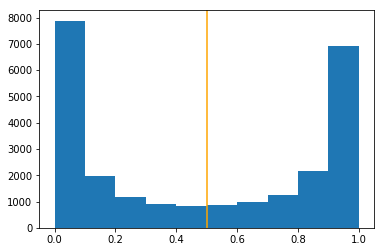

In [36]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')
 # for most of the reviews there is clear boundary (positive/negative), with a simplistic defintion of the metric 

In [37]:
# we can use the AUC_ROC%
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [38]:
"{:0.2f}".format(pct_auc)

'92.71'

In [39]:
# comparatif of individual results
# tranforming from nested lists to single list
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [40]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [41]:
ydf.head(10)

,y_hat,y
0,0.893547,1
1,0.102744,1
2,0.847956,1
3,0.903662,1
4,0.232289,1
5,0.520158,0
6,0.030079,0
7,0.064371,0
8,0.965295,1
9,0.522287,1


In [42]:
' '.join(index_word[id] for id in all_x_valid[0])

'START how his charter evolved as both man and ape was outstanding not to mention the scenery of the film christopher lambert was astonishing as lord of greystoke christopher is the soul to this masterpiece i became so with his performance i could feel my heart pounding the of the movie still moves me to this day his portrayal of john was oscar worthy as he should have been nominated for it'

In [43]:
' '.join(index_word[id] for id in all_x_valid[6]) 

"START this movie is horrible you won't believe this hunk of junk is even a movie was better then this and was pretty frigging bad too a bunch of stupid teens crash in a desert find an old run down bungalow and end up fending off horrifically badly stop motion animated spiders pardon my french but the acting was bad as hell the person who wrote this probably didn't even know what a spider is because he had the spiders living in a colony serving an alien queen ripoff queen spider spiders do not live in colonies this movie is a piece of crud at the end the marines suddenly pop out of no where and kill all the spider without even being called if you see a copy of this movie at a video store it in gasoline and throw a match at it"

In [44]:
' '.join(index_word[id] for id in all_x_valid[1]) 

"START bride of chucky starts late one night as officer bob bailey vince sneaks into the evidence room at his police station amongst all the horror film in joke props he steals the remains of the chucky doll that serial killer charles lee ray possessed way back in the original child's play 1988 he drives the remains to an isolated area where ray's ex girlfriend tiffany jennifer tilly slashes bailey's throat takes the remains back to her trailer there tiffany stitches staples chucky voiced by brad dourif back together again using a 'voodoo for book brings him back to murderous life thing don't go as tiffany had hoped chucky turns out not to be the man of her dreams after all so she locks him in a play pen at which chucky is less than happy while tiffany takes a bath chucky escapes electrocutes her using that book brings her back to life in the shape of a female doll dressed as a bride neither want to be stuck in plastic bodies have to work together to get to a cemetery in new jersey whe

In [45]:
# example of errors in the classification
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10)

,y_hat,y
21,0.920050,0
25,0.972661,0
95,0.931269,0
143,0.972241,0
150,0.940057,0
204,0.930902,0
258,0.905394,0
304,0.924582,0
470,0.916405,0
489,0.987023,0


In [46]:
' '.join(index_word[id] for id in all_x_valid[25]) 

"START committed doom and peter goes across the pond to take on the american justice system circa 1971 with this priceless piece of zeitgeist paranoia that leans so far left it falls over constantly is pure tourist as he assembles this our gang tragedy with cliché freaks hippies and black revolutionaries pitted against trigger happy cops and military and a kangaroo court tribunal made up of disapproving calcified adults making poor fashion statements talk about a revolution br br in punishment park we have radical youth versus corrupt system as dissenters convicted of crimes are given the choice of imprisonment or a three day trek across punishment park death valley and freedom of course the law enforcement officials monitoring their journey aren't about to play fair and combined with the stifling heat the fate of our protagonists looks sealed br br punishment park has elements of kafka in setting as well as theme trials are held under a large canvas tent where shackled prisoners shout

In [47]:
# positives but classified as negative
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10)

,y_hat,y
151,0.061022,1
239,0.048486,1
426,0.081084,1
543,0.054241,1
602,0.085272,1
732,0.060633,1
926,0.063169,1
927,0.036033,1
951,0.045404,1
961,0.031759,1


In [48]:
' '.join(index_word[id] for id in all_x_valid[927]) 

"START i saw it in europe plex great movie br br this film is an exploration of the spirit and the flesh in modern times protagonist jim kirk drives an unwieldy rv across america stopping often to fill his gas guzzling tank he is middle aged and confused he fuels his thick diabetic body with cups of coffee and radio chatter he is the flesh agitated and sometimes spaced out fairly oblivious to the growing tension around him but feeling it as of discomfort br br the spirit the film through speeches and other sounds as well as what appears and goes by in the visual field the spirit eventually collides with the flesh and kirk goes down unable to comprehend what has happened to him he's been in denial about just how bad things have become due to he of all of us because we are all focused on the needs and desires of our flesh we're all in the same denial and so we like kirk are in danger of going down and being blown away by desert sands just like him"

In [49]:
# there is still room for improvement of the model